# Working with automated computations: Imported and Computed tables

Welcome back! In this session, we are going to continue working with the pipeline for the mouse electrophysiology example. 

In this session, we will learn to:

* import neuron activity data from data files into an `Imported` table
* compute various statistics for each neuron by defining a `Computed` table
* define a `Lookup` table to store parameters for computation
* define another `Computed` table to perform spike detection and store the detected spikes
* automatically trigger computations for all missing entries with `populate`

First thing first, let's import `datajoint` again.

In [1]:
import datajoint as dj

As we are going to perform some computations, let's go ahead and import NumPy as well as Matplotlib.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Now we would like to continue working with the tables we defined in the previous notebook. To do so, we would need the classes for each table: `Mouse` and `Session`. We can either redefine it here, but for your convenience, we have included the schema and table class definitions in a package called `tutorial_pipeline.mouse_session`, from which you can import the classes as well as the schema object. We will use the schema object again to define more tables.

In [3]:
import sys
sys.path.append("..")
from tutorial_pipeline.mouse_session import schema, Mouse, Session

Please enter DataJoint username: root
Please enter DataJoint password: ········
Connecting root@localhost:3306


In [4]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
1,2016-11-19,M
2,2016-11-20,unknown
5,2016-12-25,F
10,2017-01-01,F
11,2017-01-03,F
100,2017-05-12,F


In [5]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2017-05-15,0,Edgar Y. Walker,
0,2017-05-19,0,Edgar Y. Walker,
5,2017-01-05,1,Fabian Sinz,
100,2017-05-25,100,Jacob Reimer,


The `mouse_session.py` also fills each table with data to make sure we are all on the same page.

# Importing data from data files

Recall from the project description
> * In each experimental session, you record electrical activity from a single neuron. You use recording equipment that produces separate data files for each neuron you recorded.

Our recording equipment produces a data file for each neuron recorded. Since we record from one neuron per session, there should be one data file for each session.

In the `data` directory, you will find `.npy` (saved NumPy array) files with names like `data_100_2017-05-25.npy`.

As you might have guessed, these are the data for the recording sessions in the `Session` table, and each file are named according to the `mouse_id` and `session_date` - the attributes of the primary keys - in the format `data_{mouse_id}_{session_date}.npy`.

So `data_100_2017-05-25.npy` is the data for session identified by `mouse_id = 100` and `session_date = "2017-05-25"`.

## Looking at the data 

Let's take a quick peak at the data file content.

First, let's pick a session to load the data for. To do this we are going to first fetch the **primary key attributes** of `Session` as a list of dictionaries. We make use of the special `fetch('KEY')` syntax to achieve this.

In [6]:
keys = Session.fetch('KEY')
keys

[{'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15)},
 {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19)},
 {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5)},
 {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25)}]

Any item in this list of keys can be used to uniquely identify a single session!

In [7]:
# ENTER YOUR CODE! - restrict session by an element of keys
Session & keys[1]

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2017-05-19,0,Edgar Y. Walker,


Let's take the first key, and generate the file name that corresponds to this session. Remember the `data_{mouse_id}_{session_date}.npy` filename convetion!

In [8]:
key = keys[0]
key

{'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15)}

In [9]:
filename = 'data/data_{mouse_id}_{session_date}.npy'.format(**key)
filename

'data/data_0_2017-05-15.npy'

Here we have made use of Python's dictionary unpacking and `format` method on strings to generate the filename from the `key`.

Finally, let's load the file.

In [10]:
data = np.load(filename)

Look at its content...

In [11]:
data

array([[ 3.57887412e-01,  4.47531558e-01,  1.96412988e-01,
         3.91114491e-01,  1.76695176e-01,  3.80088116e-01,
         9.36353656e-02,  1.10668001e-02,  1.14509759e-01,
         1.65947705e-01,  1.02058476e-01,  1.15037690e-01,
         2.18115225e-01,  1.34076355e-01,  7.74560696e-02,
         9.19639027e-02, -7.60109670e-03,  1.12814011e+00,
         9.48711628e-01,  7.77781245e-01,  5.46847747e-01,
         3.91930226e-01,  2.19542222e-01,  3.92001858e-01,
         3.17729202e-01,  2.97934834e-01,  1.85589403e-01,
         3.04215179e-01,  8.75626287e-02, -1.76018214e-02,
         1.43719730e-01, -1.28348781e-01, -4.38344653e-02,
         1.57370375e-01,  1.70233992e-01,  8.98556797e-01,
         9.36896773e-01,  1.67418776e+00,  2.48160598e+00,
         1.89737445e+00,  1.45746470e+00,  1.32137967e+00,
         1.05349900e+00,  1.88503636e+00,  1.53324759e+00,
         1.34566597e+00,  1.93924029e+00,  1.58839106e+00,
         1.26074176e+00,  1.21973014e+00,  9.80495008e-0

...and check the shape of the data.

In [12]:
data.shape

(1, 1000)

So this particular file contains a NumPy array of size 1 x 1000. This represents a (simulated) recording of raw electric activity from neuron(s) (1st dimension) over 1000 time bins (2nd dimesion).

## Defining the table for recorded neurons

We now would like to have all these recorded `Neuron` represented and stored in our data pipeline.

Since there may be multiple neurons recorded from each session, a `Neuron` can be uniquely identified by knowing the `Session` it was recorded in, as well as its `neuron_id`. For each `Neuron`, we want to store the neural activity found in the data file.

In [13]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    neuron_id: int
    ---
    activity: longblob    # electric activity of the neuron
    """

Let's check the state of our pipeline.

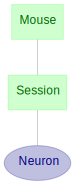

In [14]:
# ENTER YOUR CODE! - plot ERD of the schema
dj.ERD(schema)

We defined `activity` as a `longblob` so that it can store a NumPy array holding the electric activity over time. This NumPy array will be imported from the file corresponding to each neuron.

Note that our `Neuron` class inherits from `dj.Imported` instead of `dj.Manual` like others. This is because **this table's content will depend on data imported from an external file**. The `Manual` vs `Imported` are said to specify the **tier of the table**.

## DataJoint table tiers

In DataJoint, the tier of the table indicates **the nature of the data and the data source for the table**. So far we have encountered two table tiers: `Manual` and `Imported`, and we will encounter the two other major tiers in this session. 

DataJoint tables in `Manual` tier, or simply **Manual tables** indicate that its contents are **manually** entered by either experimenters or a recording system, and its content **do not depend on external data files or other tables**. This is the most basic table type you will encounter, especially as the tables at the beggining of the pipeline. In the ERD, `Manual` tables are depicted by green rectangles.

On the other hand, **Imported tables** are understood to pull data (or *import* data) from external data files, and come equipped with functionalities to perform this importing process automatically, as we will see shortly! In the ERD, `Imported` tables are depicted by blue ellipses.

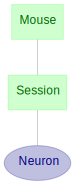

In [15]:
dj.ERD(schema)

## Importing data into the `Imported` table

Rather than filling out the content of the table manually using `insert1` or `insert` methods, we are going to make use of the `make` and `populate` logic that comes with `Imported` tables to automatically figure out what needs to be imported and perform the import!

## `make` and `populate` methods

`Imported` table comes with a special method called `populate`. Let's try calling it.

In [16]:
# ENTER YOUR CODE! - call `populate` on the table
Neuron.populate()

NotImplementedError: Subclasses of AutoPopulate must implement the method `make`

Notice that `populate` call complained that a method called `make` is not implemented. Let me show a simple `make` method that will help elucidate what this is all about.

In [17]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    ---
    activity: longblob    # electric activity of the neuron
    """
    def make(self, key): # `make` takes a single argument `key`
        print('key is', key)

Now, let's call `populate` again!

In [18]:
# ENTER YOUR CODE! - call `populate` on the table
Neuron.populate()

key is {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15)}
key is {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19)}
key is {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5)}
key is {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25)}


When you call `populate` on an `Imported` table, this triggers DataJoint to look up all tables that the `Imported` table depends on.

For **every unique combination of entries in the depended or "parent" tables**, DataJoint calls `make` function, passing in the primary key of the parent(s).

Because `Neuron` depends on `Session`, `Neuron`'s `make` method was called for each entry of `Session`

In [19]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2017-05-15,0,Edgar Y. Walker,
0,2017-05-19,0,Edgar Y. Walker,
5,2017-01-05,1,Fabian Sinz,
100,2017-05-25,100,Jacob Reimer,


Note that `make` only receives the *primary key attributes* of `Session` (`mouse_id` and `session_date`) but not the other attributes.

## Implementing `make`

Now we have a better understanding of `make`, let's implement `make` to perform the importing of data from file.

In [79]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    ---
    activity: longblob    # electric activity of the neuron
    """
    def make(self, key):
        # use key dictionary to determine the data file path
        data_file = "data/data_{mouse_id}_{session_date}.npy".format(**key)

        # load the data
        data = np.load(data_file)
        
        print('Populating neuron(s) for mouse_id={mouse_id} on session_date={session_date}'.format(**key))
        for idx, d in enumerate(data):
            # add the index of the 1st dimension as neuron_id
            key['neuron_id'] = idx
            
            # add the loaded data as the "activity" column
            key['activity'] = d

            # insert the key into self
            self.insert1(key)

            print('\tPopulated neuron {neuron_id}'.format(**key))

Notice that we added the missing attribute information `activity` into the `key` dictionary, and finally **inserted the entry** into `self` = `Neuron` table. The `make` method's job is to create and insert a new entry corresponding to the `key` into this table!

Finally, let's go ahead and call `populate` to actually populate the `Neuron` table, filling it with data loaded from data files!

In [78]:
Neuron.populate()

Populating neuron(s) for mouse_id=0 on session_date=2017-05-15
(1000,)
	Populated neuron 0
Populating neuron(s) for mouse_id=0 on session_date=2017-05-19
(1000,)
	Populated neuron 0
Populating neuron(s) for mouse_id=5 on session_date=2017-01-05
(1000,)
	Populated neuron 0
Populating neuron(s) for mouse_id=100 on session_date=2017-05-25
(1000,)
	Populated neuron 0
Populating neuron(s) for mouse_id=100 on session_date=2017-06-01
(1000,)
	Populated neuron 0


In [22]:
Neuron()

mouse_id Unique animal ID,session_date date,neuron_id,activity electric activity of the neuron
0,2017-05-15,0,=BLOB=
0,2017-05-19,0,=BLOB=
5,2017-01-05,0,=BLOB=
100,2017-05-25,0,=BLOB=


As you can obviously see, in these example datasets, we only have data for one neuron per session. 

What happens if we call `Neuron.populate` again?

In [23]:
Neuron.populate()

That's right - nothing! This makes sense, because we have imported `Neuron` for all entries in `Session` and nothing is left to be imported.

Now what happens if we insert a new entry into `Session`?

In [24]:
Session.insert1({
    "mouse_id": 100,
    "session_date": "2017-06-01",
    "experiment_setup": 1,
    "experimenter": "Jacob Reimer"
    ""
})

We can find all `Session` without corresponding `Neuron` entry with the **antijoin operator** `-`

In [25]:
# select all Session entries *without* a corresponding entry in Neuron
Session - Neuron

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
100,2017-06-01,1,Jacob Reimer,


In [26]:
Neuron.populate()

Populated neuron=0 for mouse_id=100 on session_date=2017-06-01


In [27]:
Neuron()

mouse_id Unique animal ID,session_date date,neuron_id,activity electric activity of the neuron
0,2017-05-15,0,=BLOB=
0,2017-05-19,0,=BLOB=
5,2017-01-05,0,=BLOB=
100,2017-05-25,0,=BLOB=
100,2017-06-01,0,=BLOB=


# Computations in data pipeline

Now we have successfully imported all data we have into our pipeline, it's time for us to start analyzing them! 

When you perform computations in the DataJoint data pipeline, you focus and design tables in terms of **what** is it that you are computing rather than the **how**. You should think in terms of the "things" that you are computing!

Now, let's say that we want to compute the satististics, such as mean, standard deviation, and maximum value of each of our neuron's activity traces. Hence we want to compute the neuron's **activity statistics** for each neuron!

So the new "thing" or entity here is `ActivityStatistics`, where each entry corresponds to the statistics of a single `Neuron`. Let's start designing the table, paying special attention to the dependencies.

### Statistics of neuron activities

Before we create the table to store the statistics, let's think about how we might go about computing interesting statistics for a single neuron.

Let's start by fetching one neuron to work with.

In [28]:
keys = Neuron().fetch('KEY')

# pick one key
key = keys[0]

In [29]:
Neuron() & key

mouse_id Unique animal ID,session_date date,neuron_id,activity electric activity of the neuron
0,2017-05-15,0,=BLOB=


Lets go ahead and grab the `activity` data stored as numpy array. As we learned in the last session, we can `fetch` it!

In [30]:
activity = (Neuron() & key).fetch('activity')

In [31]:
activity

array([array([ 3.57887412e-01,  4.47531558e-01,  1.96412988e-01,  3.91114491e-01,
        1.76695176e-01,  3.80088116e-01,  9.36353656e-02,  1.10668001e-02,
        1.14509759e-01,  1.65947705e-01,  1.02058476e-01,  1.15037690e-01,
        2.18115225e-01,  1.34076355e-01,  7.74560696e-02,  9.19639027e-02,
       -7.60109670e-03,  1.12814011e+00,  9.48711628e-01,  7.77781245e-01,
        5.46847747e-01,  3.91930226e-01,  2.19542222e-01,  3.92001858e-01,
        3.17729202e-01,  2.97934834e-01,  1.85589403e-01,  3.04215179e-01,
        8.75626287e-02, -1.76018214e-02,  1.43719730e-01, -1.28348781e-01,
       -4.38344653e-02,  1.57370375e-01,  1.70233992e-01,  8.98556797e-01,
        9.36896773e-01,  1.67418776e+00,  2.48160598e+00,  1.89737445e+00,
        1.45746470e+00,  1.32137967e+00,  1.05349900e+00,  1.88503636e+00,
        1.53324759e+00,  1.34566597e+00,  1.93924029e+00,  1.58839106e+00,
        1.26074176e+00,  1.21973014e+00,  9.80495008e-01,  7.66163859e-01,
        1.59531686

It's a bit subtle, but `fetch` returns a NumPy array of the attribute, even if the attribute contains a NumPy array. So here, we actually got a NumPy array of NumPy array. We can of course just index into it,

In [32]:
activity[0]

array([ 3.57887412e-01,  4.47531558e-01,  1.96412988e-01,  3.91114491e-01,
        1.76695176e-01,  3.80088116e-01,  9.36353656e-02,  1.10668001e-02,
        1.14509759e-01,  1.65947705e-01,  1.02058476e-01,  1.15037690e-01,
        2.18115225e-01,  1.34076355e-01,  7.74560696e-02,  9.19639027e-02,
       -7.60109670e-03,  1.12814011e+00,  9.48711628e-01,  7.77781245e-01,
        5.46847747e-01,  3.91930226e-01,  2.19542222e-01,  3.92001858e-01,
        3.17729202e-01,  2.97934834e-01,  1.85589403e-01,  3.04215179e-01,
        8.75626287e-02, -1.76018214e-02,  1.43719730e-01, -1.28348781e-01,
       -4.38344653e-02,  1.57370375e-01,  1.70233992e-01,  8.98556797e-01,
        9.36896773e-01,  1.67418776e+00,  2.48160598e+00,  1.89737445e+00,
        1.45746470e+00,  1.32137967e+00,  1.05349900e+00,  1.88503636e+00,
        1.53324759e+00,  1.34566597e+00,  1.93924029e+00,  1.58839106e+00,
        1.26074176e+00,  1.21973014e+00,  9.80495008e-01,  7.66163859e-01,
        1.59531686e+00,  

but if we knew that there was only one item, we can use `fetch1` instead to save some trouble

In [33]:
activity = (Neuron() & key).fetch1('activity')

In [34]:
activity

array([ 3.57887412e-01,  4.47531558e-01,  1.96412988e-01,  3.91114491e-01,
        1.76695176e-01,  3.80088116e-01,  9.36353656e-02,  1.10668001e-02,
        1.14509759e-01,  1.65947705e-01,  1.02058476e-01,  1.15037690e-01,
        2.18115225e-01,  1.34076355e-01,  7.74560696e-02,  9.19639027e-02,
       -7.60109670e-03,  1.12814011e+00,  9.48711628e-01,  7.77781245e-01,
        5.46847747e-01,  3.91930226e-01,  2.19542222e-01,  3.92001858e-01,
        3.17729202e-01,  2.97934834e-01,  1.85589403e-01,  3.04215179e-01,
        8.75626287e-02, -1.76018214e-02,  1.43719730e-01, -1.28348781e-01,
       -4.38344653e-02,  1.57370375e-01,  1.70233992e-01,  8.98556797e-01,
        9.36896773e-01,  1.67418776e+00,  2.48160598e+00,  1.89737445e+00,
        1.45746470e+00,  1.32137967e+00,  1.05349900e+00,  1.88503636e+00,
        1.53324759e+00,  1.34566597e+00,  1.93924029e+00,  1.58839106e+00,
        1.26074176e+00,  1.21973014e+00,  9.80495008e-01,  7.66163859e-01,
        1.59531686e+00,  

Now we can compute some statistics:

In [38]:
# ENTER YOUR CODE! - compute the mean of the activity
mean_activity = activity.mean()
mean_activity

0.2073565345570553

In [39]:
# ENTER YOUR CODE! - compute the standard deviation of the activity
std_activity = activity.std()
std_activity

0.4008667662130083

In [40]:
# ENTER YOUR CODE! - compute the maximum of the activity
max_activity = activity.max()
max_activity

2.481605975684647

This gives us a good idea on how to:
1. fetch the activity of a neuron knowing its primary key, and
2. compute interesting statistics

Armed with this knowledge, let's go ahead and define the table for `ActivityStatistics`

### Defining `ActivityStatistics` table

Let's go ahead and work out the definition of the table.

In [41]:
@schema
class ActivityStatistics(dj.Computed):
    definition = """
    -> Neuron
    ---
    mean: float    # mean activity
    stdev: float   # standard deviation of activity
    max: float     # maximum activity
    """

Did you notice that we are now inheriting from `dj.Computed`?  `Computed` is yet another table tier that signifies that **the entries of this table are computed using data in other tables**. `Computed` tables are represented as red circles in the ERD.

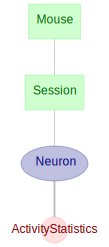

In [42]:
dj.ERD(schema)

Just like the `Imported` tables, `Computed` tables make use of the same `make` and `populate` logic for defining new entries in the table. Let's go ahead and implement `make` method.

In [47]:
# ENTER YOUR CODE! - complete the `make` method

@schema
class ActivityStatistics(dj.Computed):
    definition = """
    -> Neuron
    ---
    mean: float    # mean activity
    stdev: float   # standard deviation of activity
    max: float     # maximum activity
    """
    
    def make(self, key):
        activity = (Neuron() & key).fetch1('activity')    # fetch activity as NumPy array

        # compute various statistics on activity
        key['mean'] = activity.mean()  # compute mean
        key['stdev'] = activity.std()  # compute standard deviation
        key['max'] = activity.max()    # compute max
        self.insert1(key)
        print('Computed statistics for neuron_id {neuron_id} mouse_id {mouse_id} session_date {session_date}'.format(**key))

Let's go ahead and populate the table.

In [48]:
ActivityStatistics.populate()

Computed statistics for neuron_id 0 mouse_id 0 session_date 2017-05-15
Computed statistics for neuron_id 0 mouse_id 0 session_date 2017-05-19
Computed statistics for neuron_id 0 mouse_id 5 session_date 2017-01-05
Computed statistics for neuron_id 0 mouse_id 100 session_date 2017-05-25
Computed statistics for neuron_id 0 mouse_id 100 session_date 2017-06-01


In [49]:
ActivityStatistics()

mouse_id Unique animal ID,session_date date,neuron_id,mean mean activity,stdev standard deviation of activity,max maximum activity
0,2017-05-15,0,0.207357,0.400867,2.48161
0,2017-05-19,0,0.207357,0.400867,2.48161
5,2017-01-05,0,0.207357,0.400867,2.48161
100,2017-05-25,0,0.207357,0.400867,2.48161
100,2017-06-01,0,0.207357,0.400867,2.48161


Voila!! You have computed statistics for each neuron activity!

# Spike detection

Now, let's go ahead and tackle a more challenging computation. While having raw neural traces in itself can be quite interesting, nothing is as exciting as spikes! Let's take a look at the neurons activities and plot them.

In [50]:
# get all keys
keys = Neuron.fetch('KEY')

In [82]:
# fetch all activities - returned as NumPy array of NumPy arrays
activities = (Neuron & keys).fetch('activity')

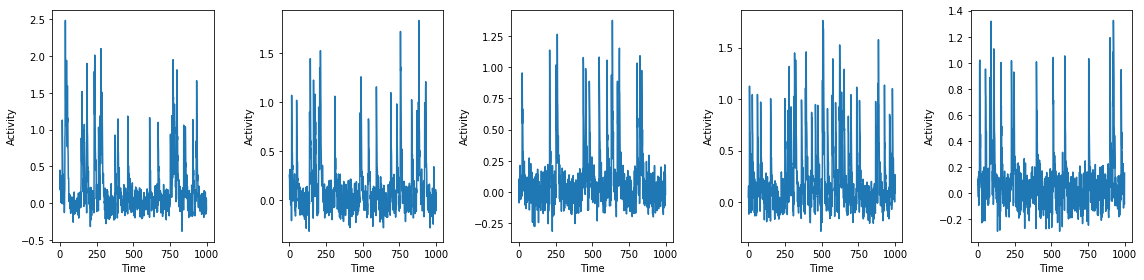

In [83]:
fig, axs = plt.subplots(1, len(activities), figsize=(16, 4))
for activity, ax in zip(activities, axs.ravel()):
    ax.plot(activity)
    ax.set_xlabel('Time')
    ax.set_ylabel('Activity')

fig.tight_layout()

Let's now focus on one trace instead.

In [84]:
key = keys[0]

In [85]:
activity = (Neuron & key).fetch1('activity')

(0, 300)

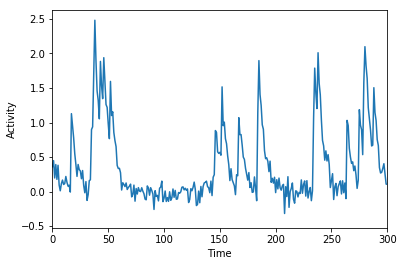

In [86]:
plt.plot(activity)
plt.xlabel('Time')
plt.ylabel('Activity')
plt.xlim([0, 300])

Perhaps we can use threshold to detect when a spike occurs. Threshold of `0.5` may be a good start.

(0, 300)

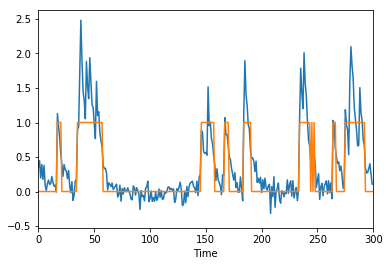

In [87]:
threshold = 0.5

# find activity above threshold
above_thrs = (activity > threshold).astype(np.int)   

plt.plot(activity)
plt.plot(above_thrs)
plt.xlabel('Time')
plt.xlim([0, 300])

We want to find out **when** it crossed the threshold. That is, find time bins where `above_thrs` goes from 0 (`False`) to 1 (`True`).

(0, 300)

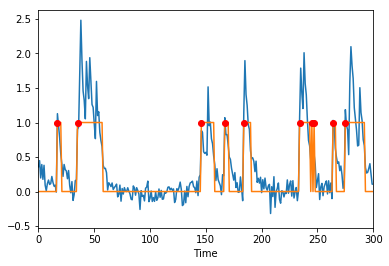

In [88]:
rising = (np.diff(above_thrs) > 0).astype(np.int)   # find rising edge of crossing threshold
spikes = np.hstack((0, rising))    # prepend 0 to account for shortening due to np.diff

plt.plot(activity)
plt.plot(above_thrs)
plt.plot(np.where(spikes>0), 1,  'ro'); # plot only spike points
plt.xlabel('Time')
plt.xlim([0, 300])

Finally, let's also compute the spike counts

In [ ]:
count = spikes.sum()   # compute total spike counts
count

Here is our complete spike detection algorithm:

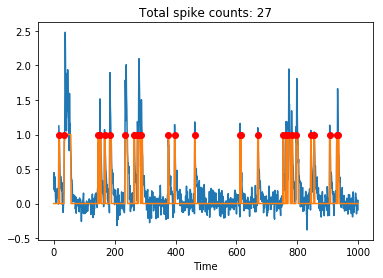

In [89]:
# ENTER YOUR CODE! - try different values of threshold!

threshold = 0.7    # enter different threshold values here

# find activity above threshold
above_thrs = (activity > threshold).astype(np.int) 

rising = (np.diff(above_thrs) > 0).astype(np.int)   # find rising edge of crossing threshold
spikes = np.hstack((0, rising))    # prepend 0 to account for shortening due to np.diff

count = spikes.sum()   # compute total spike counts


plt.plot(activity)
plt.plot(above_thrs)
plt.plot(np.where(spikes>0), 1,  'ro'); # plot only spike points
plt.xlabel('Time')
plt.title('Total spike counts: {}'.format(count));

Now notice that the exact spikes you detect depend on the value of the `threshold`. Therefore, the `threshold` is a parameter for our spike detection computation. Rather than fixing the value of the threshold, we might want to try different values and see what works well.

In other words, you want to compute `Spikes` for a **combination** of `Neuron`s and different `threshold` values. To do this while still taking advantage of the `make` and `populate` logic, you would want to define a table to house parameters for spike detection in a `Lookup` table!

## Parameter `Lookup` table

Let's define `SpikeDetectionParam` table to hold different parameter configuration for our spike detection algorithm. We are going to define this table as a `Lookup` table, rather than a `Manual` table. By now, you know that `Lookup` must be yet another **table tier** in DataJoint. `Lookup` tables are depicted by gray boxes in the ERD.

This tier indicates that the table will contain information:
* that will be referenced by other tables
* that doesn't change much - usually contains a few pre-known entries

In [90]:
@schema
class SpikeDetectionParam(dj.Lookup):
    definition = """
    sdp_id: int      # unique id for spike detection parameter set
    ---
    threshold: float   # threshold for spike detection
    """

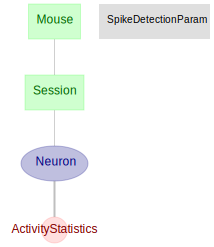

In [91]:
dj.ERD(schema)

### Defining `Spikes` table

Now let's take everything together and define the `Spikes` table. Here each entry of the table will be *a set of spikes* for a single neuron, using a particular value of the `SpikeDetectionParam`. In other words, any particular entry of the `Spikes` table is determined by **a combination of a neuron and spike detection parameters**.

We capture this by depending on both `Neuron` and `SpikeDetectionParam`. For each spike set, we want to store the detected spikes and the total number of spikes. The table definition will look something like:

In [92]:
@schema
class Spikes(dj.Computed):
    definition = """
    -> Neuron
    -> SpikeDetectionParam
    ---
    spikes: longblob     # detected spikes
    count: int           # total number of detected spikes
    """

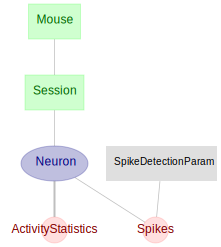

In [93]:
dj.ERD(schema)

In the ERD, we see that `Spikes` is a computed table (red circle) that depends on **both Neuron and SpikeDetectionParam**. Finally, let's go ahead and implement the `make` method for the `Spikes` table. 

In [94]:
@schema
class Spikes(dj.Computed):
    definition = """
    -> Neuron
    -> SpikeDetectionParam
    ---
    spikes: longblob     # detected spikes
    count: int           # total number of detected spikes
    """
    def make(self, key):
        print('Populating for: ', key)

        activity = (Neuron() & key).fetch1('activity')
        threshold = (SpikeDetectionParam() & key).fetch1('threshold')

        above_thrs = (activity > threshold).astype(np.int)   # find activity above threshold
        rising = (np.diff(above_thrs) > 0).astype(np.int)   # find rising edge of crossing threshold
        spikes = np.hstack((0, rising))    # prepend 0 to account for shortening due to np.diff

        count = spikes.sum()   # compute total spike counts
        print('Detected {} spikes!\n'.format(count))

        # save results and insert
        key['spikes'] = spikes
        key['count'] = count
        self.insert1(key)

The implementation of the spike detection is pretty much what we had above, except that we now fetch the value of `threshold` from the `SpikeDetectionParam` table.

Looking at the `Spikes` table, we see that it indeed inherits the primary key attributes from **both Neuron (`mouse_id`, `session_date`) and SpikeDetectionParam (`sdp_id`)**.

In [95]:
Spikes()

mouse_id Unique animal ID,session_date date,neuron_id,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes


### Populating `Spikes` table

We are now ready to populate! When we call `populate` on `Spikes`, DataJoint will automatically call `make` on **every valid combination of the parent tables - Neuron and SpikeDetectionParam**.

In [96]:
# ENTER YOUR CODE! - populate the Spikes table
Spikes.populate()

Hm... `populate` doesn't seem to be doing anything... What could be the cause?

Looking at `SpikeDetectionParam` reveals the issue:

In [97]:
SpikeDetectionParam()

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection


That's right! We have not added a detection parameter set yet. Let's go ahead and add one.

In [98]:
SpikeDetectionParam.insert1((0, 0.5))

In [99]:
SpikeDetectionParam()

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection
0,0.5


Now we should really be ready to perform the computation...

In [101]:
# ENTER YOUR CODE! - populate the Spikes table for real!
Spikes.populate()

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'neuron_id': 0, 'sdp_id': 0}
Detected 26 spikes!

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19), 'neuron_id': 0, 'sdp_id': 0}
Detected 24 spikes!

Populating for:  {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5), 'neuron_id': 0, 'sdp_id': 0}
Detected 18 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25), 'neuron_id': 0, 'sdp_id': 0}
Detected 41 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 6, 1), 'neuron_id': 0, 'sdp_id': 0}
Detected 18 spikes!



In [102]:
Spikes()

mouse_id Unique animal ID,session_date date,neuron_id,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes
0,2017-05-15,0,0,=BLOB=,26
0,2017-05-19,0,0,=BLOB=,24
5,2017-01-05,0,0,=BLOB=,18
100,2017-05-25,0,0,=BLOB=,41
100,2017-06-01,0,0,=BLOB=,18


...and we now have spike detection running!

### Trying out other parameter values

Let's see how different thresholds affect the results.

In [103]:
SpikeDetectionParam.insert1((1, 0.9))  # add another threshold

In [104]:
SpikeDetectionParam()

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection
0,0.5
1,0.9


In [105]:
# ENTER YOUR CODE! - populate the "missing" entry in Spikes table
Spikes.populate()

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'neuron_id': 0, 'sdp_id': 1}
Detected 27 spikes!

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19), 'neuron_id': 0, 'sdp_id': 1}
Detected 21 spikes!

Populating for:  {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5), 'neuron_id': 0, 'sdp_id': 1}
Detected 14 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25), 'neuron_id': 0, 'sdp_id': 1}
Detected 35 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 6, 1), 'neuron_id': 0, 'sdp_id': 1}
Detected 15 spikes!



In [106]:
Spikes()

mouse_id Unique animal ID,session_date date,neuron_id,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes
0,2017-05-15,0,0,=BLOB=,26
0,2017-05-15,0,1,=BLOB=,27
0,2017-05-19,0,0,=BLOB=,24
0,2017-05-19,0,1,=BLOB=,21
5,2017-01-05,0,0,=BLOB=,18
5,2017-01-05,0,1,=BLOB=,14
100,2017-05-25,0,0,=BLOB=,41
100,2017-05-25,0,1,=BLOB=,35
100,2017-06-01,0,0,=BLOB=,18
100,2017-06-01,0,1,=BLOB=,15


You can see that the results of spike detection under different parameter settings can live happily next to each other, without any confusion as to what is what.

## Deleting entries "upstream"

Now let's say that we decided that we don't like the first spike threshold of `0.5`. While there is really nothing wrong keeping those results around, you might decide that you'd rather delete all computations performed with that threshold to keep your tables clean.

While you can restrict `Spikes` table to the specific parameter id (i.e. `sdp_id = 0`) and delete the entries:

In [107]:
(Spikes & 'sdp_id = 0').delete()

About to delete:
`root_tutorial_pipeline`.`__spikes`: 5 items
Proceed? [yes, No]: No
Cancelled deletes.


We can simply delete the unwanted paramter from the `SpikeDetectionParam` table, and let DataJoint cascade the deletion:

In [108]:
SpikeDetectionParam() & 'sdp_id = 0'

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection
0,0.5


In [109]:
(SpikeDetectionParam() & 'sdp_id = 0').delete()

About to delete:
`root_tutorial_pipeline`.`__spikes`: 5 items
`root_tutorial_pipeline`.`#spike_detection_param`: 1 items
Proceed? [yes, No]: yes
Committed.


In [110]:
Spikes()

mouse_id Unique animal ID,session_date date,neuron_id,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes
0,2017-05-15,0,1,=BLOB=,27
0,2017-05-19,0,1,=BLOB=,21
5,2017-01-05,0,1,=BLOB=,14
100,2017-05-25,0,1,=BLOB=,35
100,2017-06-01,0,1,=BLOB=,15


# Summary

Congratulations! You have successfully extended your pipeline with a table to represent recorded data (`Neuron` as `Imported` table), tables that performs and represents computation results (`ActivityStatistics` and `Spikes` as `Computed` tables) and a table to hold computation parameters (`SpikeDetectionParam` as `Lookup` table).

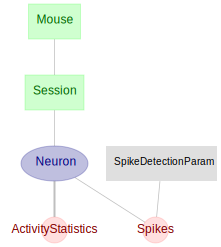

In [111]:
dj.ERD(schema)

Our pipeline is still fairly simple but completely capable of handling analysis!

In the next session, we are going to revisit some of the **design patterns** that were used when designing our pipeline. We will also tackle some more query challenges to horn in our DataJoint querying skills.